# Classic spam classification using **Spark MLLib**

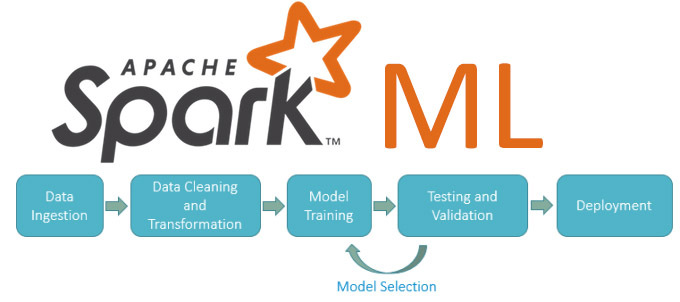

In [ ]:
!pip install pyspark

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, lit, when
from pyspark.sql.types import *
from pyspark import SparkConf
import re
from nltk.stem.snowball import SnowballStemmer

## Setting up the environment

In [ ]:
sc = SparkContext.getOrCreate()
spark = SparkSession.Builder().appName('Spam').getOrCreate()

## Read the data and print the schema

In [ ]:
df = spark.read.csv('SMSSpamCollection.csv', inferSchema = True, sep = '\t')
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)



In [ ]:
df = df.withColumnRenamed('_c0', 'class').withColumnRenamed('_c1', 'text')
df.show()

+-----+--------------------+
|class|                text|
+-----+--------------------+
|  ham|Go until jurong p...|
|  ham|Ok lar... Joking ...|
| spam|Free entry in 2 a...|
|  ham|U dun say so earl...|
|  ham|Nah I don't think...|
| spam|FreeMsg Hey there...|
|  ham|Even my brother i...|
|  ham|As per your reque...|
| spam|WINNER!! As a val...|
| spam|Had your mobile 1...|
|  ham|I'm gonna be home...|
| spam|SIX chances to wi...|
| spam|URGENT! You have ...|
|  ham|I've been searchi...|
|  ham|I HAVE A DATE ON ...|
| spam|XXXMobileMovieClu...|
|  ham|Oh k...i'm watchi...|
|  ham|Eh u remember how...|
|  ham|Fine if thats th...|
| spam|England v Macedon...|
+-----+--------------------+
only showing top 20 rows



 ## Length of the text 

In [ ]:
from pyspark.sql.functions import length
df = df.withColumn('length', length(df['text']))
df.show(3)

+-----+--------------------+------+
|class|                text|length|
+-----+--------------------+------+
|  ham|Go until jurong p...|   111|
|  ham|Ok lar... Joking ...|    29|
| spam|Free entry in 2 a...|   155|
+-----+--------------------+------+
only showing top 3 rows



In [ ]:
df.groupBy('class').mean().show()

+-----+-----------------+
|class|      avg(length)|
+-----+-----------------+
|  ham|71.45431945307645|
| spam|138.6706827309237|
+-----+-----------------+



In [ ]:
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover, IDF, StringIndexer
tokenizer = Tokenizer(inputCol = 'text', outputCol = 'tokens')
stop_remove = StopWordsRemover(inputCol = 'tokens', outputCol = 'stop_token')
tf_vec = HashingTF(inputCol = 'stop_token', outputCol = 'c_vec')
idf = IDF(inputCol = 'c_vec', outputCol = 'tf_idf')
ham_spam_to_numeric = StringIndexer(inputCol = 'class', outputCol = 'label')

## VectorAssembler

In [ ]:
from pyspark.ml.feature import VectorAssembler
clean_up = VectorAssembler(inputCols = ['tf_idf', 'length'], outputCol = 'features')

Model bulid

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes()

## Split the dataset into train and test sets

In [ ]:
train, test = df.randomSplit([0.7, 0.3])

## NLP Pipeline using Spark NLP

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[ham_spam_to_numeric, tokenizer, stop_remove, tf_vec, idf, clean_up,nb])


## Train the Model

In [ ]:
# fit the pipeline on training data
pipeline_model = pipeline.fit(train)

## Perform Predictions

In [ ]:
# perform predictions on test data
predictions =  pipeline_model.transform(test)

In [ ]:
predictions.show()

+-----+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|class|                text|length|label|              tokens|          stop_token|               c_vec|              tf_idf|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  ham| &lt;#&gt;  mins ...|    51|  0.0|[, &lt;#&gt;, , m...|[, &lt;#&gt;, , m...|(262144,[105689,1...|(262144,[105689,1...|(262145,[105689,1...|[-348.11113986815...|[1.0,9.5011788731...|       0.0|
|  ham| &lt;DECIMAL&gt; ...|   132|  0.0|[, &lt;decimal&gt...|[, &lt;decimal&gt...|(262144,[59196,71...|(262144,[59196,71...|(262145,[59196,71...|[-966.41950500966...|[1.0,7.0729760007...|       0.0|


## Evaluate the Model

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
# Make predicitons
predictionAndTarget = predictions.select("label", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})


In [ ]:
print('Accuracy:  {:2.2%} '.format(acc))
print('Precision: {:2.2%} '.format(f1))
print('Recall:    {:2.2%} '.format(weightedPrecision))
print('F1 Score:  {:2.2%} '.format(weightedRecall))

Accuracy:  96.04% 
Precision: 95.77% 
Recall:    96.12% 
F1 Score:  96.04% 
